In [1]:
import duckdb

parquet_path = "data/merged_output_parquet/*.parquet"

In [2]:
duckdb.read_parquet(f"{parquet_path}").columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'is_holiday',
 'zone_pickup',
 'borough_pickup',
 'number_of_schools_pickup',
 'number_of_pois_pickup',
 'number_of_universities_pickup',
 'zone_dropoff',
 'borough_dropoff',
 'number_of_schools_dropoff',
 'number_of_pois_dropoff',
 'number_of_universities_dropoff',
 'temperature_2m (°C)',
 'rain (mm)',
 'snowfall (cm)',
 'snow_depth (m)',
 'wind_speed_10m (km/h)',
 'wind_gusts_10m (km/h)',
 '__null_dask_index__']

In [3]:
%%time

duckdb.sql(f""" select 
                avg(passenger_count) avg_passengers, 
                avg(trip_distance),
                min(trip_distance),
                max(trip_distance),
                avg(total_amount),
                min(total_amount),
                max(total_amount) 
           from '{parquet_path}'
""")

CPU times: user 1.26 ms, sys: 1.62 ms, total: 2.87 ms
Wall time: 1.97 ms


┌────────────────────┬────────────────────┬────────────────────┬────────────────────┬───────────────────┬───────────────────┬───────────────────┐
│   avg_passengers   │ avg(trip_distance) │ min(trip_distance) │ max(trip_distance) │ avg(total_amount) │ min(total_amount) │ max(total_amount) │
│       double       │       double       │       double       │       double       │      double       │      double       │      double       │
├────────────────────┼────────────────────┼────────────────────┼────────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ 1.3935208932959393 │   5.15373921688434 │             -30.62 │          398608.62 │ 23.80983682174983 │           -2567.8 │         1000003.8 │
└────────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┴───────────────────┴───────────────────┘

In [4]:
%%time

result =  duckdb.sql(f""" select month(tpep_pickup_datetime), day(tpep_pickup_datetime), round(mean(trip_distance), 2) as avg_distance from  
           '{parquet_path}'
           group by day(tpep_pickup_datetime), month(tpep_pickup_datetime) 
           order by month(tpep_pickup_datetime), day(tpep_pickup_datetime)
""").fetchall()

CPU times: user 5.37 s, sys: 299 ms, total: 5.67 s
Wall time: 411 ms


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

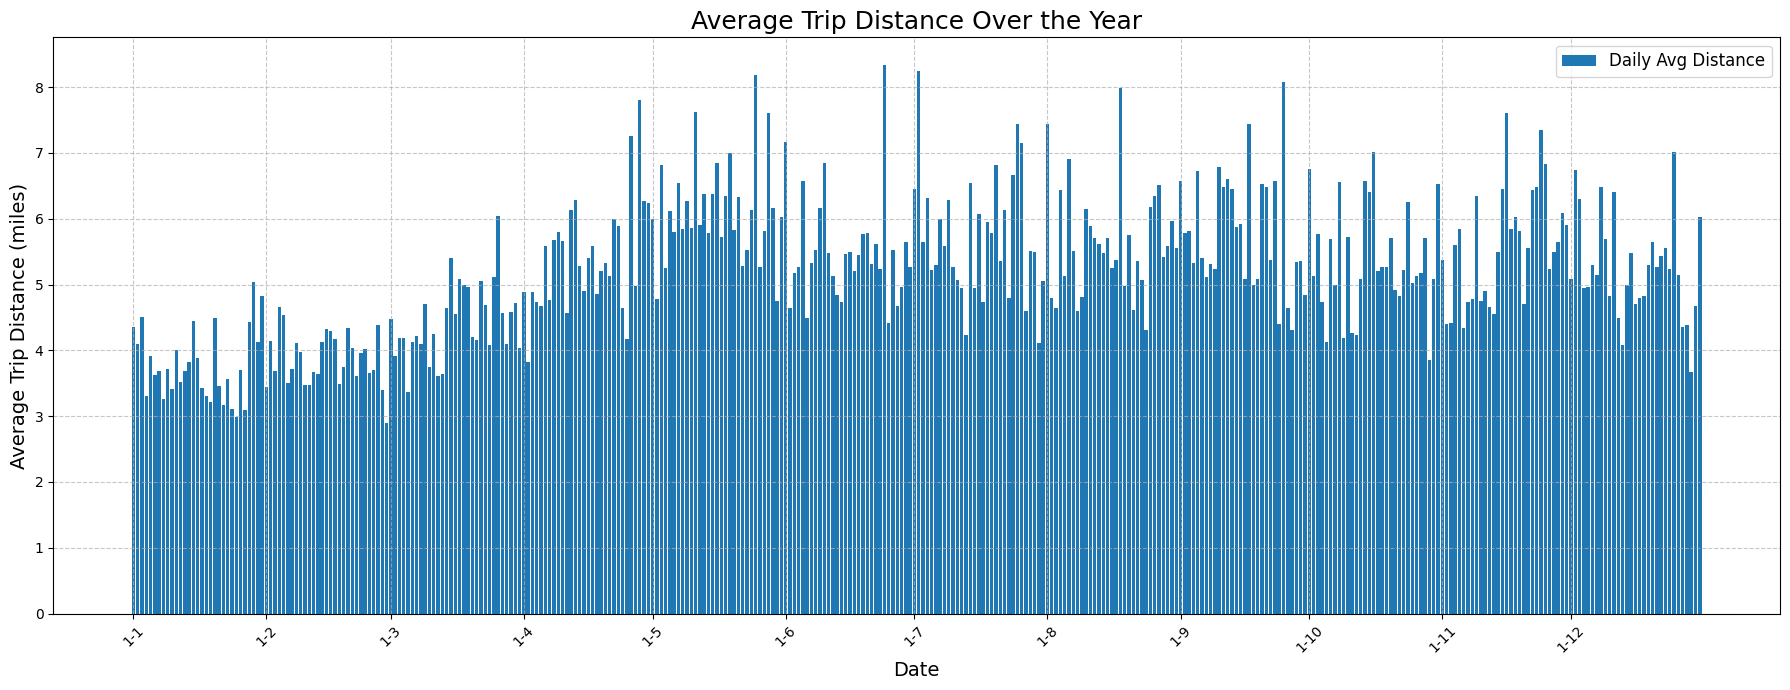

In [6]:

df = pd.DataFrame(result, columns=['month', 'day', 'avg_distance'])
df = df.sort_values(by=['month', 'day'])
df['date'] = df.apply(lambda row: str(int(row['day'])) + "-" + str(int(row['month'])), axis=1)


plt.figure(figsize=(18, 7))

plt.bar(df['date'], df['avg_distance'], label='Daily Avg Distance')

plt.title('Average Trip Distance Over the Year', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Trip Distance (miles)', fontsize=14) 

plt.xticks(rotation=45)

ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
ax.xaxis.set_major_locator(ticker.FixedLocator(df[df['day'] == 1].index))
# ax.axis.set_major_locator( df[df['day'] == 1]['date']) 

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()

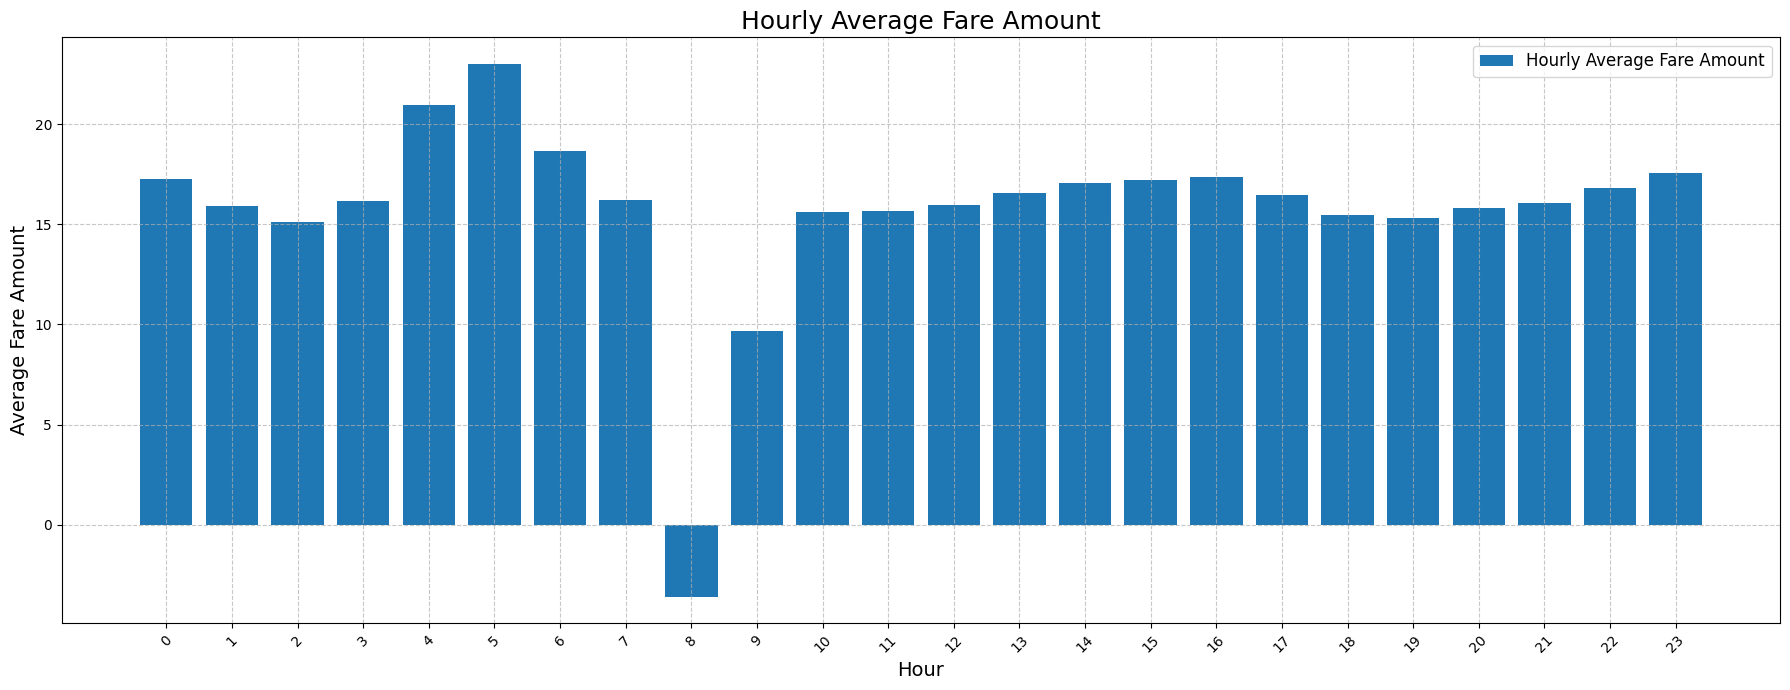

In [7]:
result =  duckdb.sql(f""" select hour(tpep_pickup_datetime), round(mean(fare_amount), 2) as avg_amount from  
           '{parquet_path}'
           group by hour(tpep_pickup_datetime)
           order by hour(tpep_pickup_datetime)
""").fetchall()

df = pd.DataFrame(result, columns=['hour', 'fare_amount'])
df = df.sort_values(by=['hour'])

plt.figure(figsize=(18, 7))

plt.bar(df['hour'], df['fare_amount'], label='Hourly Average Fare Amount')

plt.title('Hourly Average Fare Amount', fontsize=18)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Average Fare Amount', fontsize=14) 

plt.xticks(rotation=45)

ax = plt.gca()
# ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
ax.xaxis.set_major_locator(ticker.FixedLocator(df['hour'].index))
# ax.axis.set_major_locator( df[df['day'] == 1]['date']) 

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()

In [8]:
%%time
# Calculate the number of trips between each of the boroughs

duckdb.sql(f""" select borough_pickup, borough_dropoff, count(*) as trips_count from  
           '{parquet_path}'
           where borough_pickup is not null and borough_dropoff is not null
           group by borough_pickup, borough_dropoff
           order by trips_count desc
""").fetchall()

CPU times: user 9.63 s, sys: 42.7 ms, total: 9.67 s
Wall time: 674 ms


[('Manhattan', 'Manhattan', 145353094),
 ('Queens', 'Manhattan', 7891269),
 ('Manhattan', 'Queens', 5099187),
 ('Queens', 'Queens', 3773859),
 ('Manhattan', 'Brooklyn', 3750203),
 ('Queens', 'Brooklyn', 2192042),
 ('Brooklyn', 'Brooklyn', 1009253),
 ('Manhattan', 'Bronx', 755390),
 ('Brooklyn', 'Manhattan', 646438),
 ('Manhattan', 'EWR', 383396),
 ('Queens', 'Bronx', 343420),
 ('Bronx', 'Bronx', 232486),
 ('Brooklyn', 'Queens', 211598),
 ('Bronx', 'Manhattan', 193949),
 ('Bronx', 'Queens', 46498),
 ('Brooklyn', 'Bronx', 44890),
 ('Bronx', 'Brooklyn', 42528),
 ('EWR', 'EWR', 22993),
 ('Manhattan', 'Staten Island', 21335),
 ('Queens', 'Staten Island', 20424),
 ('Queens', 'EWR', 18324),
 ('Brooklyn', 'Staten Island', 5707),
 ('Staten Island', 'Brooklyn', 3838),
 ('Staten Island', 'Staten Island', 3782),
 ('Brooklyn', 'EWR', 3514),
 ('Staten Island', 'Manhattan', 2871),
 ('Staten Island', 'Queens', 2665),
 ('Bronx', 'Staten Island', 1382),
 ('Staten Island', 'Bronx', 1229),
 ('EWR', 'Manha

In [9]:
duckdb.sql(f""" select is_holiday, round(avg(trip_distance), 2), round(mean(tip_amount), 2) median_tip from  
           '{parquet_path}'
           group by is_holiday 
""")

┌────────────┬──────────────────────────────┬────────────┐
│ is_holiday │ round(avg(trip_distance), 2) │ median_tip │
│  boolean   │            double            │   double   │
├────────────┼──────────────────────────────┼────────────┤
│ false      │                         5.14 │       3.93 │
│ true       │                         5.72 │       2.89 │
└────────────┴──────────────────────────────┴────────────┘

In [10]:
duckdb.sql(f""" select round(avg(no_trips)) avg_trips_holiday from
           (
                select year(tpep_pickup_datetime), month(tpep_pickup_datetime), day(tpep_pickup_datetime), count(*) as no_trips from  
                '{parquet_path}'
                where is_holiday is true
                group by year(tpep_pickup_datetime), month(tpep_pickup_datetime), day(tpep_pickup_datetime)
           )
""")

┌───────────────────┐
│ avg_trips_holiday │
│      double       │
├───────────────────┤
│           38148.0 │
└───────────────────┘

In [11]:
duckdb.sql(f""" select round(avg(no_trips)) as avg_trips_non_holiday from
           (
                select year(tpep_pickup_datetime), month(tpep_pickup_datetime), day(tpep_pickup_datetime), round(count(*)) as no_trips from  
                '{parquet_path}'
                where is_holiday is false
                group by year(tpep_pickup_datetime), month(tpep_pickup_datetime), day(tpep_pickup_datetime)
           )
""")

┌───────────────────────┐
│ avg_trips_non_holiday │
│        double         │
├───────────────────────┤
│               91733.0 │
└───────────────────────┘

In [13]:
duckdb.sql(f""" select round(avg(trip_distance), 2), round(mean(tip_amount), 2) median_tip from  
           '{parquet_path}'
           where "rain (mm)" >= 0.5
""")

┌──────────────────────────────┬────────────┐
│ round(avg(trip_distance), 2) │ median_tip │
│            double            │   double   │
├──────────────────────────────┼────────────┤
│                         5.45 │       2.87 │
└──────────────────────────────┴────────────┘

In [14]:
duckdb.sql(f""" select round(avg(trip_distance), 2), round(mean(tip_amount), 2) median_tip from  
           '{parquet_path}'
           where "rain (mm)" < 0.5
""")

┌──────────────────────────────┬────────────┐
│ round(avg(trip_distance), 2) │ median_tip │
│            double            │   double   │
├──────────────────────────────┼────────────┤
│                         5.13 │       3.97 │
└──────────────────────────────┴────────────┘

In [15]:
from dask.distributed import Client, LocalCluster

client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
print(f"Dask Dashboard link: {client.dashboard_link}")

Dask Dashboard link: http://127.0.0.1:8787/status


In [16]:
from dask_sql import Context


parquet_path = "data/merged_output_parquet" 
c = Context()


dask_table_name = "taxi_data"
c.create_table(dask_table_name, parquet_path, format="parquet")


sql_query = f""" select borough_pickup, borough_dropoff, count(*) as trips_count from  
           '{dask_table_name}'
           where borough_pickup is not null and borough_dropoff is not null
           group by borough_pickup, borough_dropoff
           order by trips_count desc
"""

sql_query_initial = f"""
    select 
                avg(passenger_count) avg_passengers, 
                avg(trip_distance),
                min(trip_distance),
                max(trip_distance),
                avg(total_amount),
                min(total_amount),
                max(total_amount) 
           from '{dask_table_name}'
"""


In [17]:
%%time 
c.sql(sql_query_initial).compute()

CPU times: user 278 ms, sys: 46 ms, total: 324 ms
Wall time: 5.27 s


,avg_passengers,AVG(taxi_data.trip_distance),MIN(taxi_data.trip_distance),MAX(taxi_data.trip_distance),AVG(taxi_data.total_amount),MIN(taxi_data.total_amount),MAX(taxi_data.total_amount)
0,1.393521,5.153739,-30.62,398608.62,23.809837,-2567.8,1000003.8


In [18]:
%%time

c.sql(sql_query).compute()

CPU times: user 2.81 s, sys: 459 ms, total: 3.27 s
Wall time: 43.3 s


,borough_pickup,borough_dropoff,trips_count
0,Manhattan,Manhattan,145353094
7,Queens,Manhattan,7891269
5,Manhattan,Queens,5099187
1,Queens,Queens,3773859
2,Manhattan,Brooklyn,3750203
10,Queens,Brooklyn,2192042
6,Brooklyn,Brooklyn,1009253
3,Manhattan,Bronx,755390
8,Brooklyn,Manhattan,646438
19,Manhattan,EWR,383396
